# Topics in Working with Spatial Data

Below, we'll take you through a typical workflow with spatial data, including some of the tricker or more difficult parts of cleaning, aligning, and cross-referencing between datasets. We'll cover a few topics:

1. creating geographic data from flat text
2. geocoding to create geographic data using `geopy`
3. creating better maps with basemaps using `contextily`
4. building zones for visualization
5. spatial joins, & queries

First, though, we'll be mainly using the following packages:

In [1]:
import geopandas # to read/write spatial data
import matplotlib.pyplot as plt # to visualize data
import pandas # to read/write plain tables

# to display a few webpages within the notebook
from IPython.display import IFrame
%matplotlib inline

# Reading data

In many of the "clean" analysis cases, an analyst will have *prepared* data that is ready to use for spatial analysis. This may mean it comes in a variety of well-understood geographical formats (e.g. shapefiles, `tiff` rasters, geopackage `.gpkg` files, or geojson). However, it is important to understand how to create geodata from flat text files, since this is a common issue when working with databases or non-specialist databases.

Below, we will read in some data from [insideairbnb.com](https://insideairbnb.com), with data pertaining to the features & prices of airbnbs in Austin, TX. This data mimicks two common ways that geographical data is distributed, when it is distributed outside of an explicitly spatial format. 

In [2]:
neighborhoods = pandas.read_csv('../data/neighborhoods.csv')
listings = pandas.read_csv('../data/listings.csv.gz')

For the first dataset, the `listings` data, records are provided with information about the latitude & longitude of the listing:

In [3]:
listings.head()

id                        listing_url       scrape_id last_scraped  \
0  1078  https://www.airbnb.com/rooms/1078  20190514155147   2019-05-14   
1  2265  https://www.airbnb.com/rooms/2265  20190514155147   2019-05-14   
2  5245  https://www.airbnb.com/rooms/5245  20190514155147   2019-05-14   
3  5456  https://www.airbnb.com/rooms/5456  20190514155147   2019-05-14   
4  5769  https://www.airbnb.com/rooms/5769  20190514155147   2019-05-14   

                                        name  \
0          *UT/Hyde Park Craftsman Apartment   
1            Zen-East in the Heart of Austin   
2        Green, Colorful, Clean &  Cozy home   
3  Walk to 6th, Rainey St and Convention Ctr   
4                             NW Austin Room   

                                             summary  \
0  This upstairs apartment is surrounded by trees...   
1  Zen East is situated in a vibrant & diverse mu...   
2                                                NaN   
3  Fabulous location for walking to Convention Ce...   
4                                                NaN   

                                               space  \
0  The garage apartment was built in the 1920s an...   
1  This colorful and clean 1923 house was complet...   
2  Situated in a vibrant & diverse multicultural ...   
3  Cute Private Studio apartment located in Willo...   
4  Looking for a comfortable inexpensive room to ...   

                                         description experiences_offered  \
0  This upstairs apartment is surrounded by trees...                none   
1  Zen East is situated in a vibrant & diverse mu...                none   
2  Situated in a vibrant & diverse multicultural ...                none   
3  Fabulous location for walking to Convention Ce...                none   
4  Looking for a comfortable inexpensive room to ...                none   

                               neighborhood_overview  ...  \
0  Hyde Park is close to downtown, UT, 6th street...  ...   
1                                                NaN  ...   
2                                                NaN  ...   
3  My neighborhood is ideally located if you want...  ...   
4  Quiet neighborhood with lots of trees and good...  ...   

  is_business_travel_ready          cancellation_policy  \
0                        f                     flexible   
1                        f  strict_14_with_grace_period   
2                        f  strict_14_with_grace_period   
3                        f  strict_14_with_grace_period   
4                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             f                                t   
4                             t                                t   

  calculated_host_listings_count  calculated_host_listings_count_entire_homes  \
0                              2                                            2   
1                              3                                            2   
2                              3                                            2   
3                              1                                            1   
4                              1                                            0   

   calculated_host_listings_count_private_rooms  \
0                                             0   
1                                             1   
2                                             1   
3                                             0   
4                                             1   

  calculated_host_listings_count_shared_rooms  reviews_per_month  \
0                                           0               1.70   
1                                           0               0.19   
2    

We can see that there are multiple distinct pieces of usable geographic information in the list of columns in the dataframe:
1. city
2. state
3. zipcode
4. hood, which means *neighbor*hood
5. country
6. **latitude** & **longitude**, which are the coordinates of the listing
7. **geometry**, which is the well-known text representation of the point iself.

We will focus on constructing geometries from the latitude & longitude fields. 

In [4]:
list(listings.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_hood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'hood',
 'hood_cleansed',
 'hood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_p

Inspecting the second dataset, we can see only one column that might be relevant to constructing a geographical representation of the data. There, **wkb** refers to a well-known binary representation of the data. This is a common format for expressing geometric information, especially when working with spatial databases like postgis, or when geographic information is [*"shoehorned"*](https://pypi.org/project/geoparquet/) into existing flat-text file formats. Often, the well-known binary representation is a string of binary digits, encoded in hexidecimal, that represents the structure of the geometry corresponding to that record in the dataframe. Neighborhoods are *"areal"* features, meaning that they are polygons. Thus, the well-known binary column encodes the shape of these polygons. 

In [5]:
neighborhoods.head()

hood_id  hood_group                                                wkb
0    78739         NaN  01060000000100000001030000000100000077020000AC...
1    78754         NaN  01060000000100000001030000000100000074010000B1...
2    78732         NaN  0106000000010000000103000000010000009601000082...
3    78737         NaN  010600000001000000010300000001000000F1000000A4...
4    78756         NaN  010600000001000000010300000001000000DE0000007E...

# Creating geometries from raw coordinates

For the first dataset, `geopandas` has helper functions to construct a *"geodataframe"*, a subclass of `pandas` dataframe useful for working with geographic data, directly from coordinates. You can do this yourself using the `points_from_xy` function:

In [6]:
geometries = geopandas.points_from_xy(listings.longitude, listings.latitude)

Then, sending these geometries to the `GeoDataFrame` constructor, you can make a geodataframe:

In [7]:
listings = geopandas.GeoDataFrame(listings, geometry=geometries)

For the `neighborhoods` data, we must parse the well-known binary. The package that handles geometric data in Python is called `shapely`. Using the `wkb` module in `shapely`, we can parse the well-known binary and obtain a geometric representation for the neighborhoods:

In [8]:
from shapely import wkb

In [9]:
neighborhoods['geometry'] = neighborhoods.wkb.apply(lambda shape: wkb.loads(shape, hex=True))

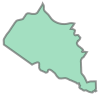

In [10]:
neighborhoods.geometry[0]

However, even though we have parsed the geometry information, we have not ensured that this data is contained within a `GeoDataFrame`. Fortunately, we can use the `GeoDataFrame` constructor, which will use whatever is in the column called `'geometry'` as the geometry for the record, by default: 

In [11]:
neighborhoods = geopandas.GeoDataFrame(neighborhoods)
neighborhoods.drop('wkb', axis=1, inplace=True)

# Writing out to file

Since it will be handy to use this data later, we will write it out to an explicit geographic data format. For now, the recommended standard in the field is the `geopackage`, although many folks use other data formats. 

Before we can proceed, however, we need to define a [*coordinate reference system*](https://en.wikipedia.org/wiki/Spatial_reference_system) for the data. This refers to the system that links the coordinates for the geometries in our database to locations on the real earth, which is not flat. Inspecting our data a little bit, we can see that the coordinates appear to be in raw longitude/latitude values:

In [12]:
listings.geometry[[0]]

0    POINT (-97.73674 30.30123)
Name: geometry, dtype: object

In [13]:
neighborhoods.geometry[[0]]

0    (POLYGON ((-97.890016 30.209412, -97.889286 30...
Name: geometry, dtype: object

The typical coordinate reference system for data in raw latitude/longitude values is `epsg:4326`. To set the "initial" coordinate system for a geodataframe, the following convention is used:

In [14]:
neighborhoods.crs = {'init': 'epsg:4326'}
listings.crs = {'init':'epsg:4326'}

Then, we can write them out to file using the `to_file` method on a geodataframe: 

In [15]:
neighborhoods.to_file('../data/neighborhoods.gpkg', driver='GPKG')

In [16]:
listings.to_file('../data/listings.gpkg', driver='GPKG')

# Finding Addresses

It's often important to be able to identify the address of a given coordiante, and to identify the coordinates that apply to a given address. To get this information, you can use a *geocoder* to work "forward," giving the coordinates that pertain to a given address, or "backward," giving the address pertaining to a given coordinate. Below, we'll show you how to use `geopy` to do both directions of geocoding. 

In [17]:
import geopy

The `geopy` package requires that you first build a "coding" object, then use that coding object to code locations. Coding forward is handled by the `geocode` method, and coding backwards is handled using the `reverse` method. 

According to the terms of service, you *must always set the user_agent* argument when using `Nominatim`, the Open Street Map geocoder. `geopy` exposes many other geocoders for simple use, but Nominatim is the simplest to work with when getting started, because it does not require an API key, and works alright for light, occasional use. 

In [18]:
coder = geopy.Nominatim(user_agent='scipy2019-intermediate-gds')

The reverse coding method takes a coordinate pair (in `(latitude,longitude)` form!) and returns a `Location` object, which contains quite a few handy bits of information about the query location. This includes a street address, as well as the raw data from the `Nominatim` API:

In [19]:
coder.reverse?

Signature:
coder.reverse(
    ['query', 'exactly_one=True', 'timeout=DEFAULT_SENTINEL', 'language=False', 'addressdetails=True'],
)
Docstring:
Return an address by location point.

:param query: The coordinates for which you wish to obtain the
    closest human-readable addresses.
:type query: :class:`geopy.point.Point`, list or tuple of ``(latitude,
    longitude)``, or string as ``"%(latitude)s, %(longitude)s"``.

:param bool exactly_one: Return one result or a list of results, if
    available.

:param int timeout: Time, in seconds, to wait for the geocoding service
    to respond before raising a :class:`geopy.exc.GeocoderTimedOut`
    exception. Set this only if you wish to override, on this call
    only, the value set during the geocoder's initialization.

:param str language: Preferred language in which to return results.
    Either uses standard
    `RFC2616 <http://www.ietf.org/rfc/rfc2616.txt>`_
    accept-language string or a simple comma-separated
    list of language code

In [20]:
address = coder.reverse((listings.latitude[0], listings.longitude[0]))

In [21]:
address

Location(314, West 37th Street, Central Austin, Austin, Travis County, Texas, 78705, USA, (30.3012555, -97.736677368905, 0.0))

In [22]:
address.raw

{'place_id': 160717268,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 382033252,
 'lat': '30.3012555',
 'lon': '-97.736677368905',
 'display_name': '314, West 37th Street, Central Austin, Austin, Travis County, Texas, 78705, USA',
 'address': {'house_number': '314',
  'road': 'West 37th Street',
  'neighbourhood': 'Central Austin',
  'city': 'Austin',
  'county': 'Travis County',
  'state': 'Texas',
  'postcode': '78705',
  'country': 'USA',
  'country_code': 'us'},
 'boundingbox': ['30.301159', '30.301353', '-97.736751', '-97.736604']}

Since it is often the case we just want the address, we might reverse geocode the first twenty Airbnb listings from their latitude and longitude using the following `apply` statement:

In [23]:
listings.head(20)[['latitude', 'longitude']]\
        .apply(lambda coord: coder.reverse(coord).address, axis=1)

0     314, West 37th Street, Central Austin, Austin,...
1     2507, East 16th Street, Chestnut, Austin, Trav...
2     2504, East 13th Street, East Austin, Austin, T...
3     105, San Marcos Street, Rainey Street Historic...
4     9422, Shady Oaks Drive, Springwoods, Jollyvill...
5     1022, Harwood Place, South River City, Austin,...
6     709, Garner Avenue, Zilker, Austin, Travis Cou...
7     1702, Mariposa Drive, Travis Heights, Austin, ...
8     1209, Bickler Road, South River City, Austin, ...
9     1116, Penion Drive, Saddlewood Estates, Mancha...
10    1502, Kenwood Avenue, Travis Heights, Austin, ...
11    2808, San Pedro Street, West Campus, Austin, T...
12    8913, Mount Bartlett Drive, The Bluffs of Grea...
13    1914, Valley Hill Circle, East Riverside - Olt...
14    1402, West 13th Street, Clarksville, Austin, T...
15    2006, Alegria Road, Abercrombie, Austin, Travi...
16    3832, Arrow Drive, Woodstone Village, Austin, ...
17    13429, Equestrian Cove, Lamplight Village,

Working in the other direction, the `geocode` method takes a known address and converts it into a location. Using our earlier geocoded address, this works like this:

In [24]:
coder.geocode(address.address)

Location(314, West 37th Street, Central Austin, Austin, Travis County, Texas, 78705, USA, (30.3012555, -97.736677368905, 0.0))

Be careful of the usage policy for the Nomiantim browser, however. There are some constraints on how Nominatim may be used. If you plan on geocoding extensively, definitely be sure to register for another service; you will get banned from using Nominatim if you send large batches of bulk geocoding requests:

In [25]:
IFrame('https://operations.osmfoundation.org/policies/nominatim/', width=800, height=800)

Take the next 5 minutes to try geocoding /reverse geocoding a few addresses/coordinates.

# Cleaning Data

As is often the case, data never arrives *perfectly* clean. Later, we'll be examining the information on the nightly price per head for Airbnbs. So, let's take a look at how clean the `price` data actually is:

In [26]:
listings.price.head()

0     $85.00
1    $225.00
2    $100.00
3     $95.00
4     $40.00
Name: price, dtype: object

Ok! The `price` data's dtype is `object`, meaning that each record is a string. The data is expressed using conventional North American price string formats, like:

> $1,234.56

Which we must process into the *pythonic* representation of a number string:

> 1_234.56

To do this, we can use string methods of the `price` column. The `.str` attribute for `pandas.Series` objects lets us refer to string methods (like `.replace()`, `.startswith()`, or `.lower()`) that will be applied to every element within that Series. Since these are standard methods, they can be chained together in a sequence, as well. So, to convert our prices, we can do the following:

In [27]:
listings['price'] = (listings.price.str.replace('$','') # replace dollars with nothing
                                  .str.replace(',','_') # swap , for _
                                  .replace('', pandas.np.nan) # an empty string is missing data
                                  .astype(float)) # and cast to a float

Now, the `price` column is a float:

In [28]:
listings.price.head()

0     85.0
1    225.0
2    100.0
3     95.0
4     40.0
Name: price, dtype: float64

and can be worked with like a float:

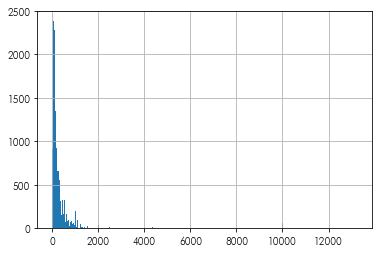

In [29]:
listings.price.hist(bins=300)

### **Woah**, 
what Airbnb costs up there at around 14k dollars/night?

In [30]:
listings.iloc[listings.price.idxmax()][['id','name','price', 'accommodates','listing_url']]

id                                           33614278
name               THE ARRIVE SAPPHIRE ON LAKE AUSTIN
price                                           13229
accommodates                                       18
listing_url     https://www.airbnb.com/rooms/33614278
Name: 11389, dtype: object

Taking a look at this listing, we see that it's a *huge* space: 

In [31]:
IFrame(src=listings.iloc[listings.price.idxmax()].listing_url, 
       width=800, height=800)

Further, quite a few prices are down at zero dollars! That's... odd! For now, let's drop values that have extremely low and high prices. 

In [32]:
listings = listings[listings.price < listings.price.quantile(.99)]
listings = listings[listings.price > listings.price.quantile(.01)]

# Basemaps

Basemaps are visual aids that sit below your data that help to contextualize information being displayed on a map. We suggest using the `contextily` package alongside `geopandas` to make great, high-quality maps from web tiles. To use `contextily`, we must first reproject our data into the Web Mercator projection, which is used for most web mapping tiles. 

In [33]:
listings = listings.to_crs(epsg=3857)
neighborhoods = neighborhoods.to_crs(epsg=3857)

The main functionality of contextily is contained within the `bounds2img` function. This function takes the bounds of a given area and returns all web tiles that intersect this area at a given zoom level. Thus, you can define a level of detail (`zoom`), and `contextily` will grab the tiles that intersect the area and return them as a numpy array.

To make this easy with `geopandas`, we can use the `total_bounds` attribute of our `GeoDataFrames`. This reflects the bounding box for the geometries inside of that `GeoDataFrame`. It is updated when data in the dataframe is changed, including when the dataframe is subsetted or appened to, so the `total_bounds` is an accurate reflection of the full extent of the data. Since we have transformed our data to the Web Mercator projection, the `total_bounds` for the data now expresses locations in terms of coordiantes within the Web Mercator system:

In [34]:
neighborhoods.total_bounds

array([-10917264.20931646,   3512350.07574952, -10858277.45829849,
         3570742.87985925])

Data in the `total_bounds` attribute is stored in `(west, south, east, north)` format typical of geospatial applications. In concept, this provides the lower left and top right corners of the map. For many imaging applications, such as in `matplotlib`, bounding box information is often given instead as `(west, east, south, north)`, so attention must be paid to the format of these bounding boxes. 

Since `contextily` uses the same format for bounding boxes as `geopandas`, you can provide the `total_bounds` coordinates to the constructor using the *unpack* operator, `*`:

In [35]:
import contextily
basemap, basemap_extent = contextily.bounds2img(*neighborhoods.total_bounds, 
                                                zoom=10)

Thus, two objects are returned. `basemap` is a numpy raster containing the actual color values for the basemap:

In [36]:
basemap

array([[[223, 224, 187],
        [225, 225, 187],
        [225, 225, 187],
        ...,
        [225, 225, 187],
        [225, 225, 187],
        [224, 223, 186]],

       [[223, 224, 187],
        [223, 224, 187],
        [225, 225, 187],
        ...,
        [225, 225, 187],
        [225, 225, 187],
        [224, 223, 186]],

       [[189, 189, 170],
        [189, 189, 170],
        [189, 189, 170],
        ...,
        [225, 225, 187],
        [225, 225, 187],
        [225, 225, 187]],

       ...,

       [[202, 209, 169],
        [197, 206, 166],
        [195, 205, 164],
        ...,
        [176, 177, 171],
        [222, 222, 185],
        [225, 225, 187]],

       [[204, 210, 171],
        [197, 206, 166],
        [195, 205, 164],
        ...,
        [207, 209, 181],
        [225, 225, 187],
        [225, 225, 187]],

       [[206, 213, 173],
        [200, 208, 167],
        [196, 204, 163],
        ...,
        [225, 225, 187],
        [225, 225, 187],
        [225, 225, 187]]

The `basemap_extent` object contains the bounding box information for this image, encoded in Web Mercator coordinates in `(west, east, south, north)` form:

In [37]:
basemap_extent

(-10918876.616480857,
 -10840605.099516837,
 3483082.504898911,
 3600489.7803449417)

This can be used with the `plt.imshow` function (which displays images from numpy arrays), to provide a basemap to any plot. For example, the following plot shows the neighborhoods and listing data together:

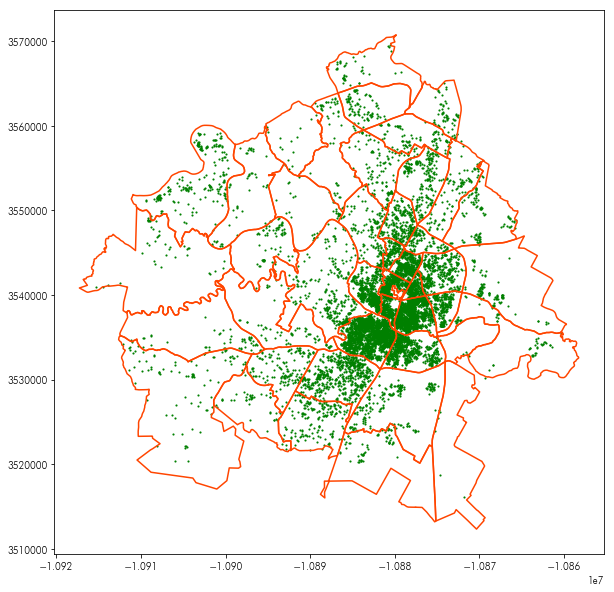

In [38]:
plt.figure(figsize=(10, 10))
neighborhoods.boundary.plot(ax=plt.gca(), color='orangered')
listings.plot(ax=plt.gca(), marker='.', markersize=5, color='green')

By adding the `basemap` in using `plt.imshow`, we can see where these points and polygons are:

array([-10917264.20931646, -10858277.45829849,   3512350.07574952,
         3570742.87985925])

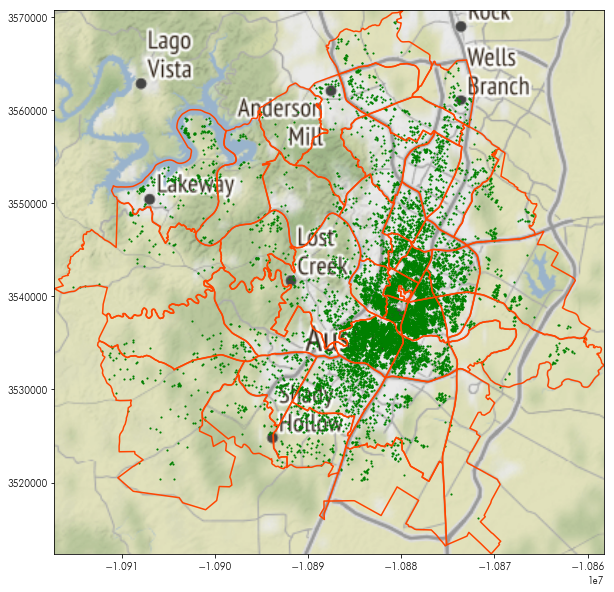

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(basemap, extent=basemap_extent, interpolation='bilinear')
neighborhoods.boundary.plot(ax=plt.gca(), color='orangered')
listings.plot(ax=plt.gca(), marker='.', markersize=5, color='green')

# and, to make sure the view is focused only on our data:
plt.axis(neighborhoods.total_bounds[[0,2,1,3]])

Contextily offers many different styles of basemap. Within the `contextily.tile_providers` module, different providers are stated, such as:
- `ST_*`, the family of [Stamen](http://maps.stamen.com/#toner/12/30.2223/-97.8365) map tiles
- `OSM_*`, the family of [Open Street Map](https://www.openstreetmap.org/#map=13/30.2635/-97.7465) map tiles. 

For instance, the following will show the very pretty Stamen Toner Light tiles:

In [40]:
tonermap, tonermap_extent = contextily.bounds2img(*neighborhoods.total_bounds, zoom=10, 
                                                  url=contextily.tile_providers.ST_TONER_LITE)

array([-10917264.20931646, -10858277.45829849,   3512350.07574952,
         3570742.87985925])

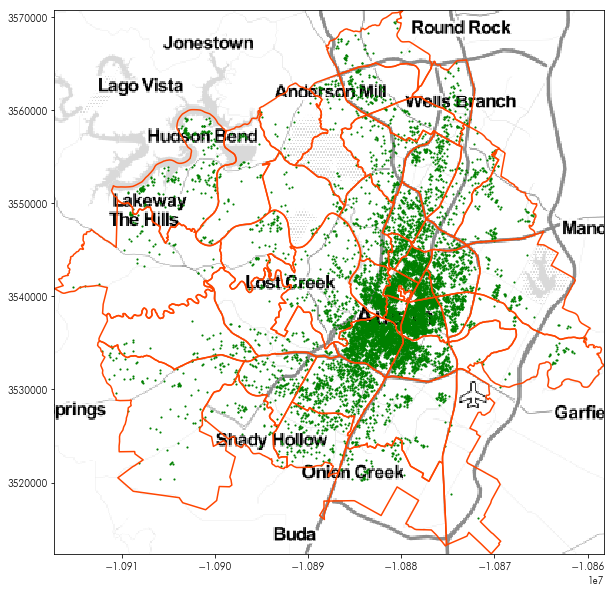

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(tonermap, extent=tonermap_extent)
neighborhoods.boundary.plot(ax=plt.gca(), color='orangered')
listings.plot(ax=plt.gca(), marker='.', markersize=5, color='green')
plt.axis(neighborhoods.total_bounds[[0,2,1,3]])

If you're interested or able to use others' tileservers, you can also format your tileserver query using `tileZ` (for zoom) and `tileX`/`tileY`, like other tileserver url formats and provide this URL to the `bounds2img` function:

In [42]:
transit = 'http://tile.memomaps.de/tilegen/tileZ/tileX/tileY.png'

In [43]:
transitmap, transitmap_extent = contextily.bounds2img(*neighborhoods.total_bounds, zoom=10, 
                                                      url=transit)

array([-10917264.20931646, -10858277.45829849,   3512350.07574952,
         3570742.87985925])

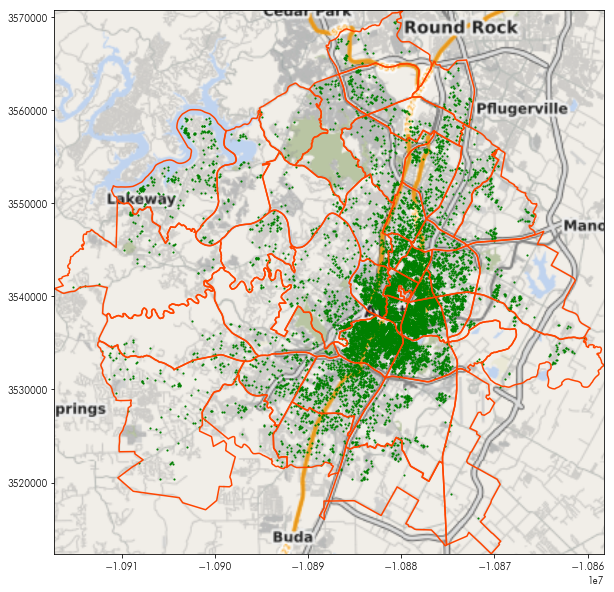

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(transitmap, extent=transitmap_extent, interpolation='bilinear')
neighborhoods.boundary.plot(ax=plt.gca(), color='orangered')
listings.plot(ax=plt.gca(), marker='.', markersize=5, color='green')
plt.axis(neighborhoods.total_bounds[[0,2,1,3]])

Using `geopy` & `contextily`, put together a map of your hometown, place of residence, or place of work.  

*hint: the bounding box of a `geopy` query is often contained in its `raw` attribute*

# Building up areas for visualization

Building areas for the visualization of spatial groups is a very useful tool. In many contexts, these areas provide a simple way to classify new data into groups, or can provide a simpler graphical frame with which large amounts of data can be visualized. 

For our puposes, Airbnb data contains a lot of information about `neighborhoods`. But, people often disagree about the naming and boundaries of their neighborhoods. From a practical perspective, our data on Airbnbs has a few different pieces of information about neighborhoods. In the `listings` dataframe, each individual Airbnb offers up some information about what "neighborhood" it falls within:

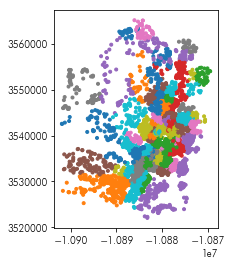

In [45]:
listings.dropna(subset=['hood']).plot('hood', marker='.')

Indeed, there are many different neighborhoods in the data:

In [46]:
(listings.groupby('hood') #group by the neighborhood
         .id.count() # get the count of observations
         .sort_values(ascending=False) # sort the counts to have the most populous first
         .head(20)) # and get the top 20

hood
East Downtown          1121
Downtown                627
Travis Heights          479
University of Texas     409
Zilker                  381
Bouldin Creek           354
East Riverside          337
Barton Hills            308
South Lamar             306
Cherry Creek            281
MLK & 183               258
Upper Boggy Creek       236
McKinney                210
Old West Austin         202
South Congress          178
Govalle                 172
Hancock                 168
Hyde Park               157
North Loop              156
Mueller                 155
Name: id, dtype: int64

One method that is used often to construct an area from point data is to consider the [*convex hull*](https://en.wikipedia.org/wiki/Convex_hull) of the data. The convex hull is like the polygon you'd get if you took a rubber band and stretched it around the most extreme points. Every point is inside of the convex hull, but some points will be on its boundary. Further, the shape is *convex*, meaning that the straight line between any two points will also be contained within the convex hull. We can build convex hulls from a group of points using the `unary_union` attribute of a `GeoSeries` (to collect them together into a single geometry), and then using the `convex_hull` method for that shape. For example

In [47]:
listings.iloc[[0,1,2,3]].geometry

0    POINT (-10880004.12859457 3542329.215247995)
1    POINT (-10877470.49698412 3539269.985790124)
2    POINT (-10877449.34628087 3539046.986199692)
3    POINT (-10879752.54654538 3537158.736811166)
Name: geometry, dtype: object

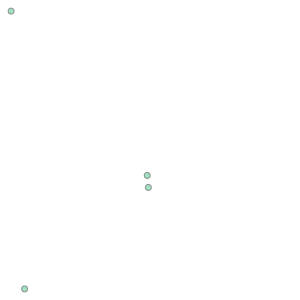

In [48]:
listings.iloc[[0,1,2,3]].geometry.unary_union

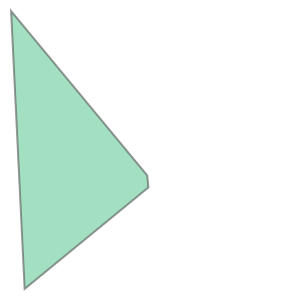

In [49]:
listings.iloc[[0,1,2,3]].geometry.unary_union.convex_hull

Since this `unary_union` is a property of any `GeoSeries` and `convex_hull` is a property of any `shapely` geometry, we can use this approach within a `groupby` as a part of a typical [split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) pattern. For instance, if we wanted to get the convex hulls for each neighborhood, we might first group by neighborhoods:

In [50]:
hood_groups = listings.groupby('hood')

Then, for each group, we'd want to do the same thing we did above: get the `unary_union.convex_hull` from that chunk:

In [51]:
chulls = hood_groups.geometry.apply(lambda hood: hood.unary_union.convex_hull)

If this worked, we will see each neighborhood next to a polygon corresponding to its convex hull:

In [52]:
chulls.head()

hood
Allendale                     POLYGON ((-10880815.64768246 3544394.903851193...
Anderson Mill                 POLYGON ((-10886743.4105672 3561154.690549185,...
Angus Valley                  POLYGON ((-10879230.45813356 3556757.413625068...
Balcones Civic Association    POLYGON ((-10881092.83321453 3550307.580134824...
Balcony Woods                 POLYGON ((-10878861.99061904 3554630.333175564...
Name: geometry, dtype: object

It did work! All that is needed now is to build a `GeoDataFrame` from these hulls for further analysis & mapping:

In [53]:
chulls = geopandas.GeoDataFrame(chulls.reset_index())

Since these convex hulls are now a standard geodataframe, we can make a map using them, just like we did the neighborhoods before:

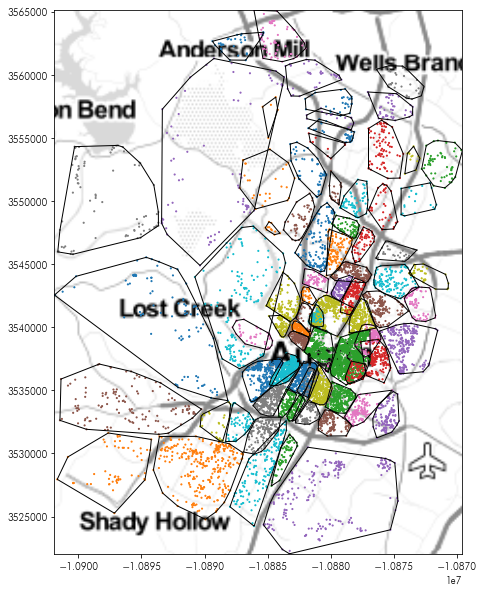

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(tonermap, extent=tonermap_extent, interpolation='bilinear')
chulls.boundary.plot(linewidth=1, color='k', ax=plt.gca())
listings.dropna(subset=['hood']).plot('hood', ax=plt.gca(), 
                                      marker='.', markersize=5)
plt.axis(chulls.total_bounds[[0,2,1,3]])
plt.show()

#### **Hmm...**
There are some weird overlaps there:

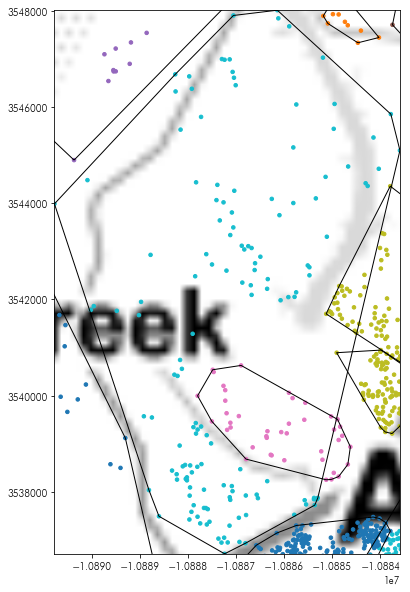

In [55]:
plt.figure(figsize=(10,10))
plt.imshow(tonermap, extent=tonermap_extent, interpolation='bilinear')
chulls.boundary.plot(ax=plt.gca(), linewidth=1, color='k')
listings.dropna(subset=['hood']).plot('hood', ax=plt.gca(), 
                                      marker='.', markersize=50)
plt.axis(chulls.query('hood == "Westlake Hills"').total_bounds[[0,2,1,3]])
plt.show()

The convex hull of the larger set of points can't help but be too large; it's shape is intrinsically not convex! The indentation where the other smaller group of points fall simply cannot be accommodated using the convex hull. 

Another common kind of hull for analysis purposes is the `alpha` shape. [Alpha shapes](https://en.wikipedia.org/wiki/Alpha_shape) reflect a kind of non-convex optimally-tight hull that can be used to analyze groups of points. One implementation of this algorithm is in the Python Spatial Analysis Library, `pysal`. It takes an array of coordinates and returns the polygon corresponding to the Alpha Shape

In [56]:
from pysal.lib.cg import alpha_shape_auto
from pysal.lib.weights.distance import get_points_array

Thus, like before, we can get the coordinates from each group and compute the alpha shape for the coordinates. We do this in a similar fashion to how the convex hulls were built:

In [57]:
ashapes = hood_groups.geometry.apply(lambda hood: alpha_shape_auto(
                                                  get_points_array(hood)))
ashapes = geopandas.GeoDataFrame(ashapes.reset_index())

These new boundaries are no longer forced to be convex, and can be incredibly non-convex:

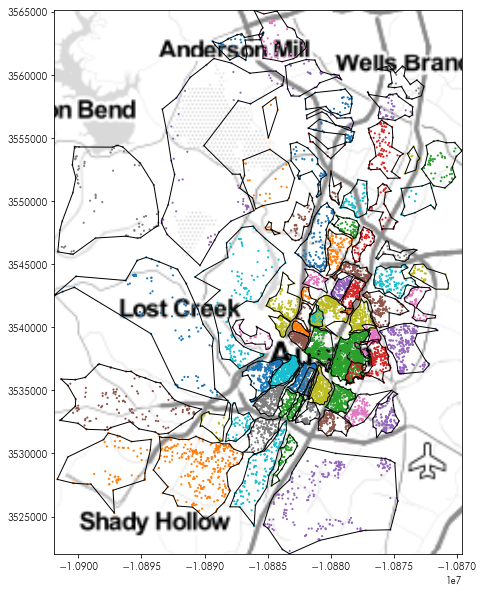

In [58]:
plt.figure(figsize=(10,10))
plt.imshow(tonermap, extent=tonermap_extent, interpolation='bilinear')
ashapes.boundary.plot(color='k', linewidth=1, ax=plt.gca())
listings.dropna(subset=['hood']).plot('hood', ax=plt.gca(), 
                                      marker='.', markersize=5)
plt.axis(ashapes.total_bounds[[0,2,1,3]])
plt.show()

So, the overlap seen earlier does not show up: 

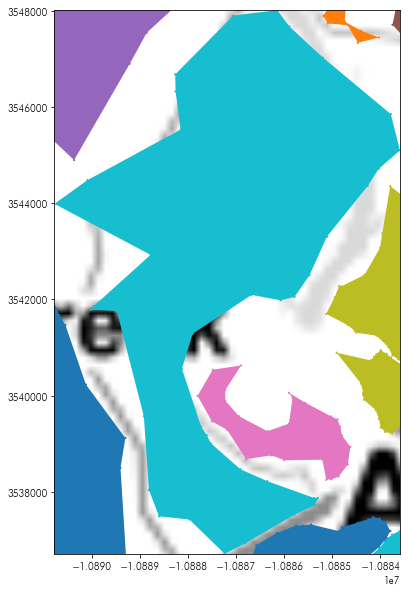

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(tonermap, extent=tonermap_extent, interpolation='bilinear')
ashapes.plot('hood', ax=plt.gca(), linewidth=2)
listings.dropna(subset=['hood']).plot('hood', ax=plt.gca(), 
                                      marker='.', markersize=5)
plt.axis(ashapes.query('hood == "Westlake Hills"').total_bounds[[0,2,1,3]])
plt.show()

# Spatial Joins

But, we have the `neighborhoods` data as well. How do these relate to the neighborhoods we've just built?

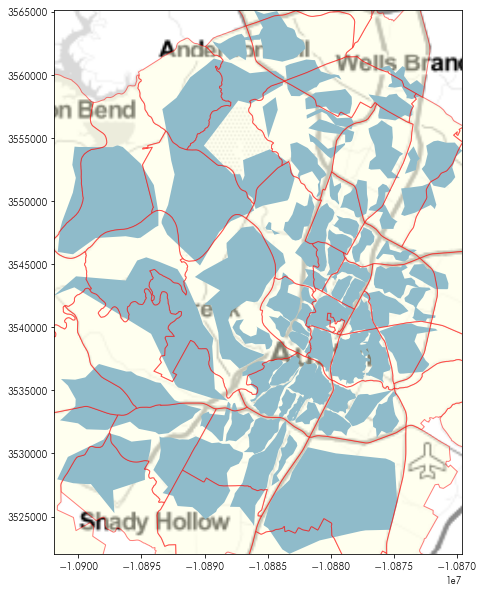

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(tonermap, extent=tonermap_extent, interpolation='bilinear')
ashapes.plot(linewidth=1, ax=plt.gca())
neighborhoods.plot(ax=plt.gca(), alpha=.5, 
                   edgecolor='red', facecolor='lightyellow')
plt.axis(ashapes.total_bounds[[0,2,1,3]])
plt.show()

It looks like there are many neighborhoods where the neighborhood stated in the listing isn't the neighborhood provided by the `insideairbnb` project. To see how the two relate to one another, we can use a spatial join. 

Spatial joins are used to relate recrods in a spatial database. To join two spatial tables together using a spatial join, you first need to think of what the *spatial query* is that is answered by the spatial join. Common spatial queries that are answered by spatial joins might be:

1. How many fire stations are within each residential district?
2. Which rivers flow under a street? 
3. What is the most common political yard sign on each street segment?

In each of these cases, we're seeking to answer a question about the relationship between two spatial datasets. In the first, we're asking how many fire stations (a point- or a polygon-based geometry) fall within a residential district (a polygon-based geometry). In the second, we're asking how many rivers (a line- or a polygon-based geometry) flow underneath a street (a line- or polygon-based geometry). In the last, we are asking what the most common yard sign (a point-based geometry) on each street segment (a line-based geometry). The spatial relationshps used for each of these queries would depend on the order used in the join. For instance, *fire stations* **within** *residential districts* would indicate a *within* relation, but reversing the spatial relationship yields a valid query as well *residential districts* **contain** *fire stations*. Formally speaking, the spatial relationships considered by spatial joins are defined formally by the [*Dimensionally-Extended 9-Intersection Model*](https://en.wikipedia.org/wiki/DE-9IM), but most common joins are stated in terms of one of three operations:

1. **A intersects B**: the final table contains records that unite the features of A and B for each pair of observations whose geometries intersect in any manner. 
2. **A contains B**: the final table contains records that unite the features of A and B for each pair of observations where the record in A "contains", or fully covers, the record in B
3. **A is within B**: the final table contains records that unite the features of A and B for each pair of observations where the record in A is within a record of B

When feature `a` contains feature `b`, then feature `b` is within feature `a`. These can be thought of as the inverse relations of one another. 

For us to discover which listings are **within** each neighborhood, we can specify the **within** `op` (short for *operation*) in the `geopanda.sjoin` function:

In [61]:
listings_in_hoods = geopandas.sjoin(listings, neighborhoods, op='within')

In total, there are three relations supported by `geopandas`. 
- Intersects: a record from the left table intersects a record from the left table.
- Within: a record from the left table is within a record from the right table.
- Contains: a record from the left table contains a record from the right table. 

The result from a spatial join creates a table where each row combines the left and right dataframes when the spatial operation is `True`. We can see that the index and `hood_id` from the `neighborhoods` table is brought alongside the `id` and `hood` data from the `listing` table:

In [62]:
listings_in_hoods.head()[['id', 'hood', 'index_right', 'hood_id']]

id                 hood  index_right  hood_id
0    1078  University of Texas           31    78705
11  21145          West Campus           31    78705
23  50318  University of Texas           31    78705
39  73289  University of Texas           31    78705
74  84771  University of Texas           31    78705

In this new joint table, we can count the different neighborhoods from the `listing` table that fall within each neighborhood from the `neighborhood` table:

In [63]:
compositions = listings_in_hoods.groupby(('hood', 'hood_id')).id.count()
compositions

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


hood                        hood_id
Allendale                   78731       37
                            78756       42
                            78757       50
Anderson Mill               78729        5
                            78750       27
Angus Valley                78727       27
                            78759        3
Balcones Civic Association  78731        1
                            78759       50
Balcony Woods               78758       26
                            78759       10
Barton Creek                78733       24
                            78735       30
                            78738        5
                            78746       33
Barton Hills                78704      228
                            78746       80
Bouldin Creek               78704      354
Brentwood                   78756       67
                            78757       59
Bryker Woods                78703       33
                            78705        1
Bull Creek        

To reformat this in a manner that can be easier to use, we can restate it in terms of the square join matrix by unstacking it and replacing the `NaN` values with something easier on the eyes, like a '-' string:

In [64]:
compositions.unstack().fillna('-')

hood_id                    78701 78702 78703 78704 78705 78712 78717 78719  \
hood                                                                         
Allendale                      -     -     -     -     -     -     -     -   
Anderson Mill                  -     -     -     -     -     -     -     -   
Angus Valley                   -     -     -     -     -     -     -     -   
Balcones Civic Association     -     -     -     -     -     -     -     -   
Balcony Woods                  -     -     -     -     -     -     -     -   
Barton Creek                   -     -     -     -     -     -     -     -   
Barton Hills                   -     -     -   228     -     -     -     -   
Bouldin Creek                  -     -     -   354     -     -     -     -   
Brentwood                      -     -     -     -     -     -     -     -   
Bryker Woods                   -     -    33     -     1     -     -     -   
Bull Creek                     -     -     -     -     -     -     -     -   
Canyon Mesa                    -     -     -     -     -     -     -     -   
Cat Mountian                   -     -     -     -     -     -     -     -   
Cherry Creek                   -     -     -     -     -     -     -     -   
Circle C                       -     -     -     -     -     -     -     -   
Clarksville                    -     -   128     -     -     -     -     -   
Copperfield                    -     -     -     -     -     -     -     -   
Crestview                      -     -     -     -     -     -     -     -   
Dawson                         -     -     -   104     -     -     -     -   
Downtown                     593     -    34     -     -     -     -     -   
East Congress                  -     -     -     -     -     -     -     -   
East Downtown                  -  1121     -     -     -     -     -     -   
East Riverside                 -     -     -     1     -     -     -     -   
Galindo                        -     -     -   120     -     -     -     -   
Gateway                        -     -     -     -     -     -     -     -   
Georgian Acres                 -     -     -     -     -     -     -     -   
Govalle                        -   172     -     -     -     -     -     -   
Gracywoods                     -     -     -     -     -     -     -     -   
Hancock                        -     -     -     -    27     -     -     -   
Highland                       -     -     -     -     -     -     -     -   
...                          ...   ...   ...   ...   ...   ...   ...   ...   
Pleasant Valley                -     -     -     -     -     -     -     -   
Rainey Street                 28     -     -     -     -     -     -     -   
Rollingwood                    -     -     -     -     -     -     -     -   
Rosedale                       -     -     -     -     -     -     -     -   
Rosewood                       -   138     -     -     -     -     -     -   
SW Williamson Co.              -     -     -     -     -     -     4     -   
Scofield Ridge                 -     -     -     -     -     -     -     -   
South Congress                 -     -     -   178     -     -     -     -   
South First                    -     -     -    57     -     -     -     -   
South Lamar                    -     -     -   306     -     -     -     -   
South Manchaca                 -     -     -     1     -     -     -     -   
St. Edwards                    -     -     -    95     -     -     -     -   
St. Johns                      -     -     -     -     -     -     -     -   
Steiner Ranch                  -     -     -     -     -     -     -     -   
Sunset Valley                  -     -     -     -     -     -     -     -   
Tarrytown                      -     -   125     -     -     -     -     -   
Travis Heights                 -     -     -   479     -     -     -     -   
University Hills               -     -     -     -     -     -     -     -   
University of Texas   

From here, we could make a map of the number of neighborhoods that listings *say* they are in veruss the neighborhoods Airbnb uses internally. To do this, we would need to get the *number* of neighborhood names from the `listings` table that occur within each neighborhood from the `neighborhood` table.  

To do this, we might first group the spatially-joined table `listings_in_hoods` by the `hood_id` (from the `neighborhood` table) and get the unique `hood` names (from the `listing` table) that occur in that group:

In [65]:
listings_in_hoods.dropna(subset=['hood']).groupby('hood_id').hood.unique()

hood_id
78701       [Downtown, Rainey Street, University of Texas]
78702    [East Downtown, Govalle, Holly, Rosewood, Uppe...
78703    [Clarksville, Tarrytown, Old West Austin, West...
78704    [Travis Heights, Zilker, Barton Hills, Dawson,...
78705    [University of Texas, West Campus, Hancock, Br...
78712                                [University of Texas]
78717                                  [SW Williamson Co.]
78719                                           [McKinney]
78721                                          [MLK & 183]
78722               [Upper Boggy Creek, Rosewood, Mueller]
78723    [Windsor Park, Pecan Spings, Mueller, Universi...
78724                     [Pecan Spings, University Hills]
78725                                          [MLK & 183]
78726                                        [Long Canyon]
78727    [Scofield Ridge, Angus Valley, Lamplight Villa...
78728                                     [Scofield Ridge]
78729    [SW Williamson Co., Anderson Mill, Long

The length of this list of unique names is the length of unique hood names within each neighborhood from the `neighborhood` dataframe:

In [66]:
number_unique = listings_in_hoods.dropna(subset=['hood']).groupby('hood_id')\
                                 .hood.unique().apply(len)

In [67]:
number_unique.head()

hood_id
78701     3
78702     5
78703     7
78704    12
78705     5
Name: hood, dtype: int64

Then, to merge this back into the neighborhoods frame, we can use a typical aspatial table merge:

In [68]:
saidhoods_in_hood = neighborhoods.merge(number_unique.to_frame('number_names'),
                                        how='left', 
                                        left_on='hood_id', right_index=True)

And (finally) make a map of the number of neighborhood names that hosts *say* within each neighborhood Airbnb uses for analytics:

array([-10917264.20931646, -10858277.45829849,   3512350.07574952,
         3570742.87985925])

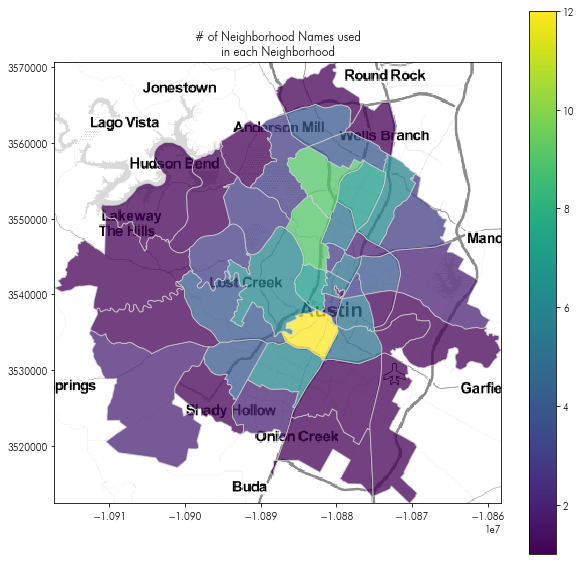

In [69]:
plt.figure(figsize=(10,10))
plt.imshow(tonermap, extent=tonermap_extent)
saidhoods_in_hood.plot('number_names', ax = plt.gca(), 
                       alpha=.75, edgecolor='lightgrey', legend=True)
plt.title('# of Neighborhood Names used\nin each Neighborhood')
plt.axis(saidhoods_in_hood.total_bounds[[0,2,1,3]])

### What do nearby airbnbs look like?

Another kind of spatial "join" focuses on merging two datasets together by their proximity, rather than by one of the spatial relations discussed above. These queries often are used to ask questions like:

1. What is the nearest restaurant to my hotel? 
2. How many bars are within a 20-minute walk of the conference center?

This distance-based query can *occasionally* be answered focusing explicitly on DE-9IM-style queries like we discussed above. For instance, response 2 can be answered using a *buffer*. In spatial analysis, a **buffer** is the polygon developed by extending the boundary of a feaure by a pre-specified distance. For example, given the points below:

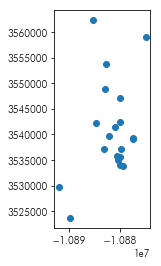

In [70]:
listings.head(20).plot()

The buffer of these points would "inflate" these points into a circle of a specified distance:

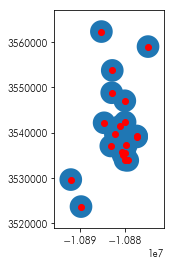

In [71]:
ax = listings.head(20).buffer(2500).plot()
listings.head(20).plot(ax=ax, color='red')

For a polygon or line, a buffer works similarly:

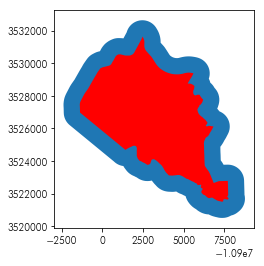

In [72]:
ax = neighborhoods.iloc[[0]].buffer(1000).plot()
neighborhoods.iloc[[0]].plot(color='red', ax=ax)

As such, a query like 

> what is the average price per head in 1000 meters around each Airbnb

can be reframed in terms of a *spatial join* between the *1000 meter buffer* around each airbnb and the original Airbnbs themselves. To do this for Airbnbs in Downtown Austin, we could do the following few steps. 

First, we can pick the two downtown neighborhoods in our dataset:

In [73]:
downtown_hoods = ('Downtown', 'East Downtown')

And then, using the standard pandas `DataFrame.query` functionality, focus the analysis on only the neighborhoods in the downtown:

In [74]:
downtown_listings = listings.query('hood in @downtown_hoods')

Then, we can build a buffer around each Airbnb using the `buffer` method:

In [75]:
searchbuffer = downtown_listings.buffer(1000)

This returns a `GeoSeries`, the `geopandas` analogue of the `pandas.Series`. 

In [76]:
searchbuffer.head()

1     POLYGON ((-10876470.49698412 3539269.985790124...
2     POLYGON ((-10876449.34628087 3539046.986199692...
3     POLYGON ((-10878752.54654538 3537158.736811166...
42    POLYGON ((-10877325.43067341 3539148.81789493,...
44    POLYGON ((-10877790.74614493 3535433.136137632...
dtype: object

We can use this to build a dataframe where the values are the price per head at each airbnb, and the geometry is the buffer. We'll keep the `id` from the `downtown_listings` dataframe as well. 

In [77]:
searchbuffer = geopandas.GeoDataFrame(downtown_listings.price.values/downtown_listings.accommodates.values,
                                      geometry=searchbuffer.tolist(), 
                                      columns=['buffer_pph'], 
                                      index=downtown_listings.id.values)
searchbuffer.crs = downtown_listings.crs
searchbuffer.head()

buffer_pph                                           geometry
2265    56.250000  POLYGON ((-10876470.49698412 3539269.985790124...
5245    50.000000  POLYGON ((-10876449.34628087 3539046.986199692...
5456    31.666667  POLYGON ((-10878752.54654538 3537158.736811166...
74716   18.750000  POLYGON ((-10877325.43067341 3539148.81789493,...
75174   43.333333  POLYGON ((-10877790.74614493 3535433.136137632...

Then, we can compute the average price within 1000 meters of each Airbnb by finding *which* 1000 meter buffers intersect each Airbnb listing:

In [78]:
listing_buffer_join = geopandas.sjoin(downtown_listings, searchbuffer, op='intersects')

However, we want to ensure that there are no "self-joins." Since a buffer of 1000 meters around a point intersects the point itself, we must remove self-joins from the final query. Since we indexed the `searchbuffer` frame using the `id` field, we can drop all entries where `id == index_right`. 

In [79]:
listing_buffer_join = listing_buffer_join.query('id != index_right')

Now, each record in `listing_buffer_join`  describes the relationship between an Airbnb and a 1-km buffer around a *different* Airbnb. By grouping together all records with the same `id`, we can summarize the prices of the nearby buffers. 

In [80]:
downtown_areasummaries = listing_buffer_join.groupby('id').buffer_pph.describe()

For an indication of what this looks like, we can look at the head of the dataframe:

In [81]:
downtown_areasummaries.head()

count       mean        std        min        25%      50%        75%  \
id                                                                             
2265   222.0  57.536552  46.378936   6.500000  29.000000  40.3125  69.812500   
5245   229.0  57.085217  45.990329   6.500000  28.750000  41.2500  69.250000   
5456   417.0  72.705886  69.951196   7.666667  33.333333  50.0000  77.000000   
74716  260.0  57.276730  45.729743   8.500000  29.791667  42.2500  65.416667   
75174   92.0  58.892689  46.247607  15.000000  32.375000  49.7500  67.500000   

         max  
id            
2265   300.0  
5245   300.0  
5456   500.0  
74716  300.0  
75174  300.0

There, there are 222 other Airbnbs within a single kilometer of listing 2265, and the average price per head of those listings is \$57.53 dollars per night.

To link this back up with the original data, we can merge the `downtown_areasummaries` back up with the `downtown_listings` since they both share the listing `id`:

In [82]:
downtown_areasummaries = downtown_listings.merge(left_on='id', 
                                                 right=downtown_areasummaries,
                                                 right_index=True, how='left')

Then, we can plot these "surrounding characteristics", showing the spatially-smoothed average of prices in the downtown Austin area:

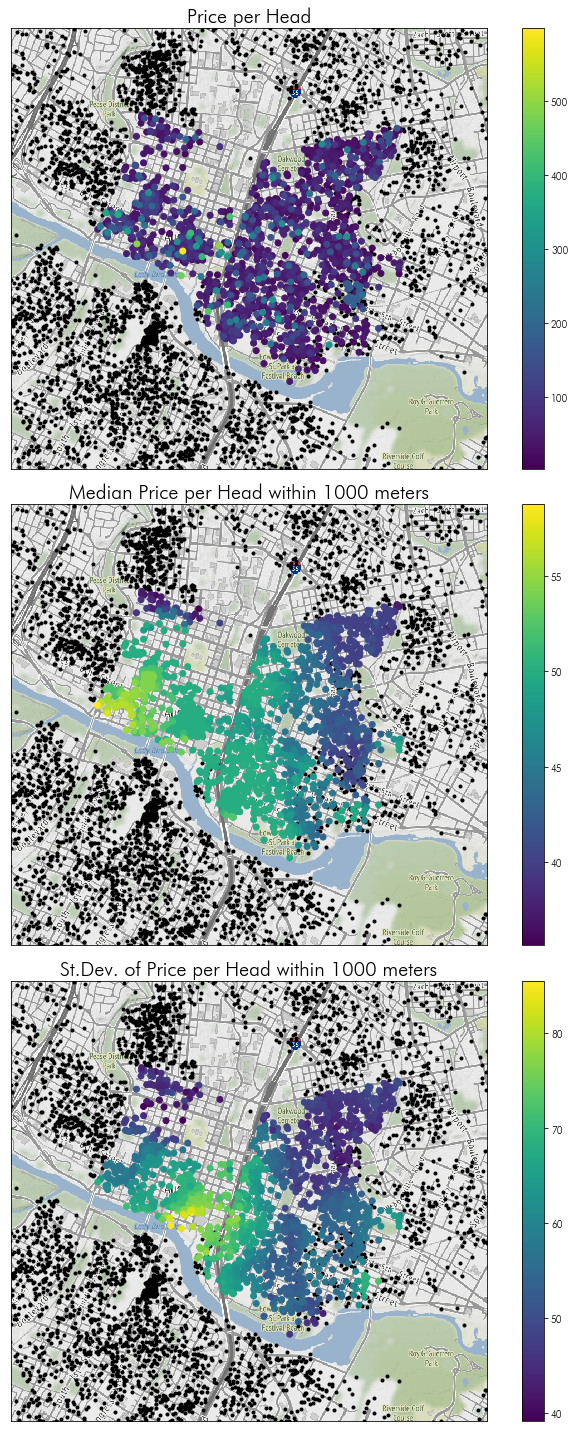

In [83]:
f, ax = plt.subplots(3,1,figsize=(10,20), sharex=True, sharey=True)
downtown_basemap, downtown_basemap_extent = contextily.bounds2img(*downtown_listings.buffer(1500).total_bounds, zoom=14)
for ax_ in ax:
    listings.plot(color='k', marker='.', ax=ax_)
    ax_.set_xticks([])
    ax_.set_xticklabels([])
    ax_.set_yticks([])
    ax_.set_yticklabels([])
    ax_.imshow(downtown_basemap, extent=downtown_basemap_extent)
    
downtown_listings.eval('price_per_head = price / accommodates')\
                 .sort_values('price_per_head', ascending=True)\
                 .plot('price_per_head', 
                       ax=ax[0], legend=True)

downtown_areasummaries.sort_values('50%', ascending=True)\
        .plot('50%', ax=ax[1], legend=True)
downtown_areasummaries.sort_values('50%', ascending=True)\
        .plot('std', ax=ax[2], legend=True)


ax[1].axis(listings.query('hood in @downtown_hoods').total_bounds[[0,2,1,3]])
ax[0].set_title('Price per Head', fontsize=20)
ax[1].set_title('Median Price per Head within 1000 meters', fontsize=20)
ax[2].set_title('St.Dev. of Price per Head within 1000 meters', fontsize=20)
ax[0].axis(downtown_listings.buffer(1500).total_bounds[[0,2,1,3]])

f.tight_layout()

### Moving beyond a toy problem...

this gets difficult to process. The join between the buffer polygons and the listings becomes very computationally intensive, even when spatial indices are used. Therefore, it can be easier, especially when dealing with point queries, to use a *K-D Tree.* These are special data structures (provided by `scipy`) that allow for exactly these kinds of queries. A useful helper function as well is provided by `pysal`, namely the `get_points_array` function. This function extracts the coordinates of all vertices for a variety of geometry packages in Python and returns a `numpy` array. 

In [84]:
from pysal.lib.weights.distance import get_points_array
import numpy

To do this distance-based price join for the whole map, then, we need to extract the coordinates and the prices of all the Airbnb listings:

In [85]:
coordinates = get_points_array(listings.geometry)
prices = listings.price.values / listings.accommodates.values

Then, we must build the `KDTree` using `scipy`. For nearly any application, the `cKDTree` will be faster. `KDTree` is an implementation of the datastructure in pure Python, whereas the `cKDTree` is an implementation in Cython.

In [86]:
from scipy.spatial import cKDTree

`KDTrees` are objects. We will tend to use the `query_*` methods from the KDTree. KDTrees in `scipy` are built when instantiated, and typically the instantiation is an expensive enough computation for large datasets that you will want to avoid re-computing the tree itself if you plan to query from it multiple times. 

In [87]:
kdt = cKDTree(coordinates)

There are many `query_*` functions on the KDTree. We will use the `query_ball_tree` function to do the same thing as we did above:

In [88]:
kdt.query_ball_tree?

Docstring:
query_ball_tree(self, other, r, p=2., eps=0)

Find all pairs of points whose distance is at most r

Parameters
----------
other : cKDTree instance
    The tree containing points to search against.
r : float
    The maximum distance, has to be positive.
p : float, optional
    Which Minkowski norm to use.  `p` has to meet the condition
    ``1 <= p <= infinity``.
eps : float, optional
    Approximate search.  Branches of the tree are not explored
    if their nearest points are further than ``r/(1+eps)``, and
    branches are added in bulk if their furthest points are nearer
    than ``r * (1+eps)``.  `eps` has to be non-negative.

Returns
-------
results : list of lists
    For each element ``self.data[i]`` of this tree, ``results[i]`` is a
    list of the indices of its neighbors in ``other.data``.
Type:      builtin_function_or_method


In [89]:
neighbors = kdt.query_ball_tree(kdt, 1000)

The `query_ball_tree` function returns a list of lists, where the $i$th list indicates the set of neighbors to the $i$th observation that are closer than $r$ to $i$. 

In [90]:
numpy.asarray(neighbors[0])

array([    0,    79,    80,    83,    84,    87,   112,   291,   376,
         468,   509,   522,   523,   541,   557,   605,   612,   620,
         640,   657,   701,   709,   717,   742,   770,   789,   869,
        1091,  1094,  1114,  1125,  1224,  1376,  1398,  1526,  1579,
        1736,  1921,  1941,  1979,  2008,  2013,  2034,  2059,  2131,
        2138,  2239,  2282,  2320,  2344,  2362,  2427,  2510,  2556,
        2648,  2718,  2732,  2901,  2940,  2958,  3011,  3246,  3278,
        3284,  3322,  3368,  3371,  3377,  3389,  3402,  3455,  3542,
        3567,  3609,  3654,  3722,  3771,  3779,  3847,  3903,  3931,
        3935,  3964,  4064,  4067,  4143,  4153,  4185,  4246,  4303,
        4380,  4501,  4637,  4652,  4690,  4791,  4797,  4822,  5013,
        5121,  5216,  5348,  5391,  5585,  5618,  5659,  5704,  5739,
        5746,  5824,  5846,  5956,  5957,  6147,  6252,  6585,  6646,
        6773,  6791,  6812,  6834,  6899,  6981,  7046,  7061,  7122,
        7152,  7183,

To summarize this in the same fashion we did before, we must *again* remove self-neighbors. There are many ways to optimize this, since it is both embarassingly parallel and can be forced to work with arrays, but we opt for simplicity in using this generator below:

In [91]:
neighbors = ([other for other in i_neighbors if other != i] for i,i_neighbors in enumerate(neighbors))

Then, to get the same information as above (the median & standard deviation of prices for nearby Airbnbs), we can use the following summary helper function:

In [92]:
def summarize(ary):
    return numpy.median(ary), numpy.std(ary)

and compute the summary of the *prices* at each neighbor:

In [93]:
summary = numpy.asarray([summarize(prices[neighbs]) for neighbs in neighbors]) 

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Since the input data is in the same order as the `listings` dataframe, we can assign directly back to the original dataframe:

In [94]:
medians, deviations = zip(*summary)
listings['median_pph_1km'], listings['std_pph_1km'] = medians, deviations

And we can make a similar sort of map as to that focusing on Downtown above, but for the whole of Austin:

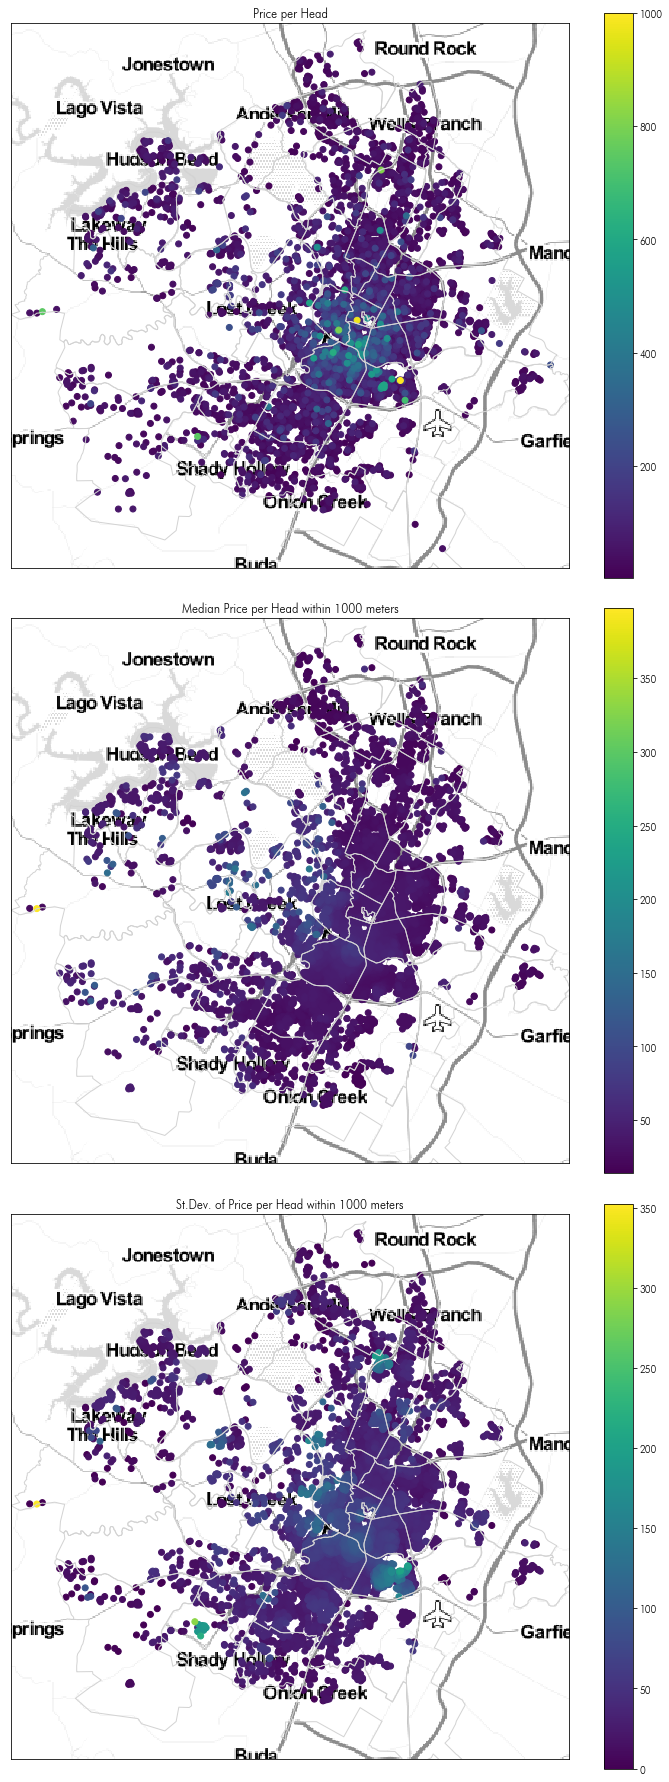

In [95]:
f, ax = plt.subplots(3,1,figsize=(10,25), sharex=True, sharey=True)
    
listings.eval('price_per_head = price / accommodates')\
        .sort_values('price_per_head', ascending=True)\
        .plot('price_per_head', ax=ax[0], legend=True)

listings.sort_values('median_pph_1km', ascending=True)\
        .plot('median_pph_1km', ax=ax[1], legend=True)
listings.sort_values('std_pph_1km', ascending=True)\
        .plot('std_pph_1km', ax=ax[2], legend=True)


ax[0].set_title('Price per Head')
ax[1].set_title('Median Price per Head within 1000 meters')
ax[2].set_title('St.Dev. of Price per Head within 1000 meters')

for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_xticklabels([])
    ax_.set_yticks([])
    ax_.set_yticklabels([])
    ax_.imshow(tonermap, extent=tonermap_extent)
    ax_.axis(listings.buffer(2000).total_bounds[[0,2,1,3]])
    neighborhoods.plot(ax=ax_, edgecolor='lightgrey', facecolor='none')

f.tight_layout()

### How about nearest neighbor joins?

The KDTree *also* works for queries about the properties of *nearest* points as well. For instance, it may be helpful to know how homogenous the types of Airbnbs are across Austin. Areas with many Airbnbs all of the same type (e.g. `Entire home/apt`) may be areas where the market for temporary housing is relatively homogenous in its offerings overall. Thus, we might define a distinction between Airbnbs which are fully "private" and those that involve some kind of shared component by building an indicator variable for whether or not a listing is shared in some manner:

In [96]:
is_shared = ~ (listings.room_type=="Entire home/apt")

Then, we can build a KDTree for each type of listing:

In [97]:
shared_kdt = cKDTree(coordinates[is_shared])
alone_kdt = cKDTree(coordinates[~ is_shared])

And, using the `query` function, find which is the nearest listing in the *other* group:

In [98]:
shared_kdt.query?

Docstring:
query(self, x, k=1, eps=0, p=2, distance_upper_bound=np.inf, n_jobs=1)

Query the kd-tree for nearest neighbors

Parameters
----------
x : array_like, last dimension self.m
    An array of points to query.
k : list of integer or integer
    The list of k-th nearest neighbors to return. If k is an 
    integer it is treated as a list of [1, ... k] (range(1, k+1)).
    Note that the counting starts from 1.
eps : non-negative float
    Return approximate nearest neighbors; the k-th returned value 
    is guaranteed to be no further than (1+eps) times the 
    distance to the real k-th nearest neighbor.
p : float, 1<=p<=infinity
    Which Minkowski p-norm to use. 
    1 is the sum-of-absolute-values "Manhattan" distance
    2 is the usual Euclidean distance
    infinity is the maximum-coordinate-difference distance
distance_upper_bound : nonnegative float
    Return only neighbors within this distance.  This is used to prune
    tree searches, so if you are doing a series of nea

Reading that docstring, we can see that the `query` function returns two things in a tuple. The first is the distance from the observation on the left to the observation on the right. The second is the *index* of the right observation. These are always sorted by the distances, so that the nearest observation corresponds to the first distance, and the second observation to the second distance, etc. 

Thus, using the query across the two groups provides the nearest entry to each observation in each group:

In [99]:
nearest_unshared_dist, nearest_unshared_ix = shared_kdt.query(coordinates[~is_shared], k=1)
nearest_alone_dist, nearest_alone_ix = alone_kdt.query(coordinates[is_shared], k=1)

Pause, for a moment before moving on to answer for yourself:
> why can't we just use one query? 

> (*hint: think of each city's nearest other city amongst LA, San Francisco, and Chicago. Is the relationship always symmetric?*)

With this in mind, we can assign the two distances together into a single vector. Since the indices are positions (i.e. not *names*), we can convert them back to the names in the dataframe by indexing the `listings.index` array using their values. 

In [100]:
listings.loc[~is_shared, 'nearest_othertype'] = listings.index[nearest_unshared_ix]
listings.loc[is_shared, 'nearest_othertype'] = listings.index[nearest_alone_ix]

Since the distances correspond directly to the indices, we can simply assign those directly:

In [101]:
listings.loc[~is_shared, 'nearest_othertype_dist'] = nearest_unshared_dist
listings.loc[is_shared, 'nearest_othertype_dist'] = nearest_alone_dist

Then, we can visualize the distances to the nearest different type of accommodation, like before:

Text(0.5, 1.0, 'Distance to different type of accommodation (m)')

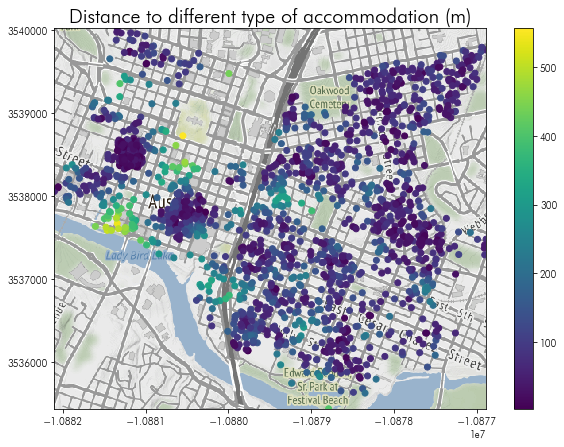

In [102]:
f = plt.figure(figsize=(10,7))
plt.imshow(downtown_basemap, extent=downtown_basemap_extent)
listings.query('hood in @downtown_hoods').plot('nearest_othertype_dist', ax=plt.gca(), legend=True)
plt.axis(downtown_listings.total_bounds[[0,2,1,3]])
plt.title('Distance to different type of accommodation (m)', fontsize=20)

Now, we will pause for a short break & questions before moving to the problemset, `relations-problemset.ipynb`. 